In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DWA_CARD_TOI_FCT'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DWA_CARD_TOI_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DWA_CARD_TOI_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 17241


In [20]:
df

,COMPANY_KEY,COMPANY_CDE,SUB_BRANCH_KEY,SUB_BRANCH_CDE,CUSTOMER_KEY,CUSTOMER_CDE,FIN_ACCOUNT,CARD_NO,CARD_CDE,SUB_INDUSTRY_CDE,...,PRODUCT_CDE,NII_CARD_MTD,NII_CARD_LY,NII_CARD_L12M,NII_CARD_L6M,NII_CARD_YTD,PROCESS_DT,REC_CREATE_DT,REC_UPDATE_DT,NII_CARD_FULL
0,1,VNI,344,VN0011341,20177998,8997303,00000000000001698343,512341XXXXXX1746,3366452146,7311,...,5000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2020-10-31,2020-11-18 14:41:57,2020-11-18 14:41:57,NaN
1,1,VNI,344,VN0011341,26916000,8821264,00000000000002116149,356480XXXXXX1448,3791209293,4231,...,3025,0.000000e+00,5.268967e+05,2.282018e+05,2.282018e+05,2.282018e+05,2020-10-31,2020-11-18 14:41:57,2020-11-18 14:41:57,NaN
2,1,VNI,556,VN0014113,35024307,14600859,00000000000002964633,472074XXXXXX0063,3812934929,4231,...,1022,-1.084253e+05,0.000000e+00,1.225863e+06,1.225863e+06,1.117438e+06,2020-10-31,2020-11-18 14:41:57,2020-11-18 14:41:57,NaN
3,1,VNI,122,VN0011556,33172691,1971887,00000000000002500144,970403XXXXXX0005,3269126003,4241,...,9023,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2021-01-31,2022-01-05 13:31:28,2022-01-05 13:31:28,NaN
4,1,VNI,210,VN0012273,30561185,2107681,00000000000002327024,356481XXXXXX9336,3269342576,7311,...,3019,-6.933981e+04,1.678995e+06,1.678995e+06,1.781232e+06,-6.933981e+04,2021-01-31,2022-01-05 13:31:28,2022-01-05 13:31:28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17236,1,VNI,119,VN0011552,30505158,7464569,00000000000001590729,356481XXXXXX0647,3034794838,4243,...,3035,1.991286e+06,2.770806e+07,2.853163e+07,1.487534e+07,7.435404e+06,2022-03-31,2022-06-02 17:21:37,2022-06-02 17:21:37,7.435404e+06
17237,1,VNI,361,VN0011704,45053585,16886539,00000000000003444183,970403XXXXXX0333,3308918410,3011,...,9039,4.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+04,2022-06-30,2022-08-25 09:42:03,2022-08-25 09:42:03,4.000000e+04
17238,1,VNI,5,VN0011614,31436007,10773651,00000000000002982234,472074XXXXXX5067,3394942811,4241,...,1025,0.000000e+00,-4.449842e+04,-2.539260e+03,0.000000e+00,0.000000e+00,2022-05-31,2022-08-03 10:53:07,2022-08-03 10:53:07,3.044011e+05
17239,1,VNI,550,VN0014091,21559981,9764792,00000000000002612373,472075XXXXXX4503,3093728677,4243,...,2022,0.000000e+00,1.241418e+06,-7.326741e+04,-7.417377e+03,-5.523335e+03,2022-06-30,2022-08-25 09:42:03,2022-08-25 09:42:03,4.353878e+06


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,COMPANY_KEY,0.000000,int64,1,0.000058,[1]
1,COMPANY_CDE,0.000000,object,1,0.000058,[VNI]
2,SUB_BRANCH_KEY,0.000000,int64,330,0.019140,"[344, 556, 122]"
3,SUB_BRANCH_CDE,0.000000,object,328,0.019024,"[VN0011341, VN0014113, VN0011556]"
4,CUSTOMER_KEY,0.000000,int64,822,0.047677,"[20177998, 26916000, 35024307]"
5,CUSTOMER_CDE,0.000000,object,632,0.036657,"[8997303, 8821264, 14600859]"
6,FIN_ACCOUNT,0.000000,object,729,0.042283,"[00000000000001698343, 00000000000002116149, 0..."
7,CARD_NO,0.000000,object,758,0.043965,"[512341XXXXXX1746, 356480XXXXXX1448, 472074XXX..."
8,CARD_CDE,0.000000,object,761,0.044139,"[3366452146, 3791209293, 3812934929]"
9,SUB_INDUSTRY_CDE,0.000000,object,38,0.002204,"[7311, 4231, 4241]"


In [22]:
df.describe()

,COMPANY_KEY,SUB_BRANCH_KEY,CUSTOMER_KEY,DAO_KEY,NII_CARD_MTD,NII_CARD_LY,NII_CARD_L12M,NII_CARD_L6M,NII_CARD_YTD,NII_CARD_FULL
count,17241.0,17241.000000,1.724100e+04,17241.000000,1.724100e+04,1.724100e+04,1.724100e+04,1.724100e+04,1.724100e+04,7.453000e+03
mean,1.0,229.239603,3.265896e+07,42832.218607,1.386758e+05,1.429105e+06,1.603966e+06,8.411070e+05,9.453804e+05,4.214412e+06
std,0.0,182.610860,6.578094e+06,8959.189026,5.057673e+05,3.348677e+06,3.561603e+06,1.999848e+06,2.364414e+06,8.664711e+06
min,1.0,1.000000,6.835540e+05,25460.000000,-1.010119e+07,-2.553866e+07,-3.258777e+07,-2.655501e+07,-1.966336e+07,-4.087176e+07
25%,1.0,77.000000,3.041716e+07,34431.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.162445e+05
50%,1.0,204.000000,3.311386e+07,43429.000000,0.000000e+00,9.867619e+04,2.282018e+05,3.602579e+04,4.732985e+04,1.096211e+06
75%,1.0,337.000000,3.633125e+07,47885.000000,1.357223e+05,1.680003e+06,2.039573e+06,1.071445e+06,9.936346e+05,5.216314e+06
max,1.0,715.000000,4.672348e+07,68757.000000,1.564948e+07,2.866625e+07,3.391104e+07,1.808776e+07,3.102962e+07,1.019546e+08


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID', 'SUB_SECTOR_CDE', 'SMS_PHONE', 'ACCT_ID', ''
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
6,FIN_ACCOUNT,0.000000,object,729,0.042283,"[00000000000001698343, 00000000000002116149, 0..."
8,CARD_CDE,0.000000,object,761,0.044139,"[3366452146, 3791209293, 3812934929]"
9,SUB_INDUSTRY_CDE,0.000000,object,38,0.002204,"[7311, 4231, 4241]"
11,SUB_SEGMENT_CDE,0.000000,object,2,0.000116,"[-1, 190 ]"
16,PRODUCT_CDE,0.000000,object,109,0.006322,"[5000, 3025, 1022]"
17,NII_CARD_MTD,0.000000,float64,9474,0.549504,"[0.0, -108425.34, -69339.80936]"
18,NII_CARD_LY,0.000000,float64,1117,0.064787,"[0.0, 526896.66038, 1678994.72145]"
19,NII_CARD_L12M,0.000000,float64,12436,0.721304,"[0.0, 228201.80404, 1225863.46]"
20,NII_CARD_L6M,0.000000,float64,11582,0.671771,"[0.0, 228201.80404, 1225863.46]"
21,NII_CARD_YTD,0.000000,float64,9650,0.559712,"[0.0, 228201.80404, 1117438.12]"


00000000000002283166    72
00000000000001025575    58
00000000000000454110    58
00000000000000311728    58
00000000000001287436    58
                        ..
00000000000003620922     2
00000000000003725978     2
00000000000003668674     2
00000000000003610932     2
00000000000003709863     2
Name: FIN_ACCOUNT, Length: 729, dtype: int64

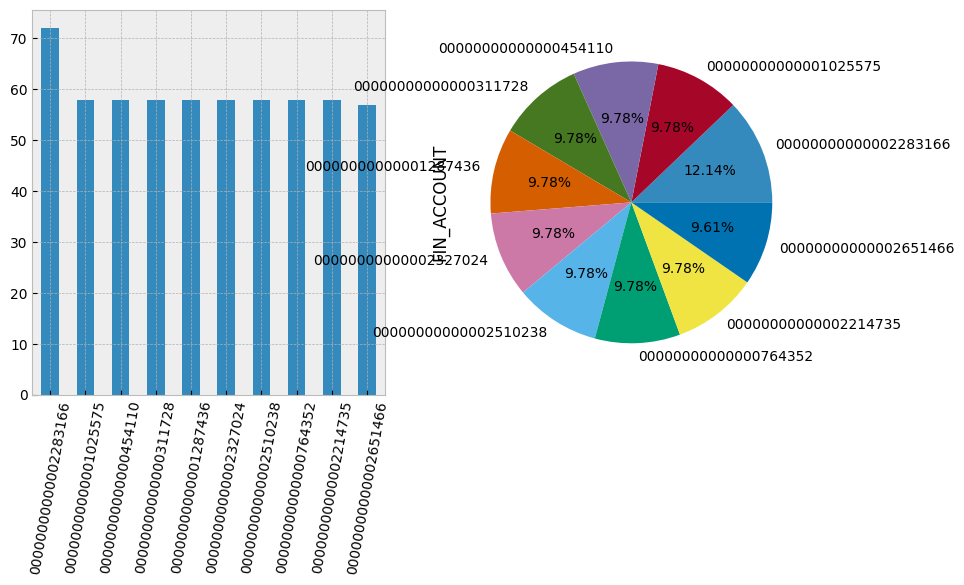

3999835170    35
3046352815    35
3773668201    35
3133558472    35
3394942811    35
              ..
3122992302     2
3650129012     2
3551136371     2
3931895969     2
3200904104     2
Name: CARD_CDE, Length: 761, dtype: int64

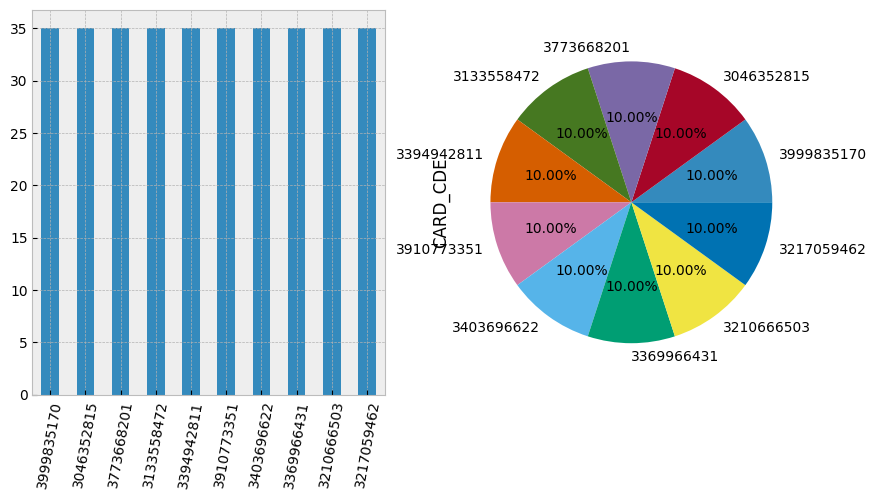

4231    6418
7311    4235
4243    1228
4241     917
1011     768
424      631
3012     606
4711     441
9001     272
3611     226
5011     174
3011     147
4511     135
1018     125
1541     116
1014     116
1020     105
101      103
4011      82
731       62
1013      50
3511      35
3099      35
3029      35
3016      35
1411      23
154       23
1211      23
1511      23
1681      12
1520       8
3211       7
1214       7
2513       5
3619       5
1412       3
1531       3
1552       2
Name: SUB_INDUSTRY_CDE, dtype: int64

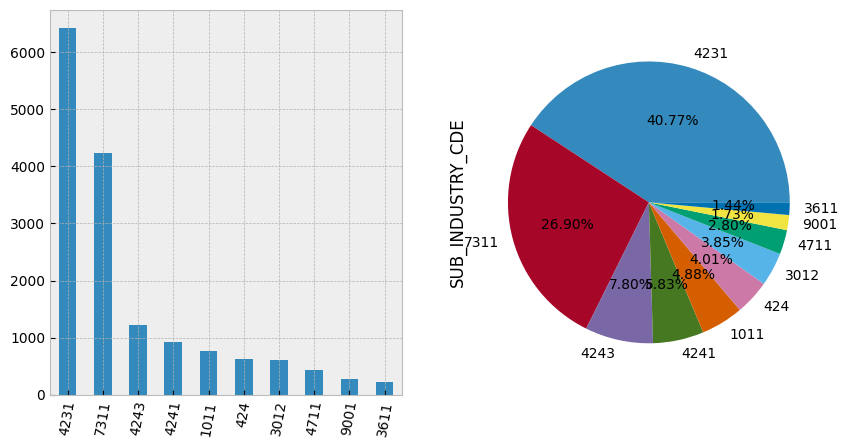

-1            17124
190             117
Name: SUB_SEGMENT_CDE, dtype: int64

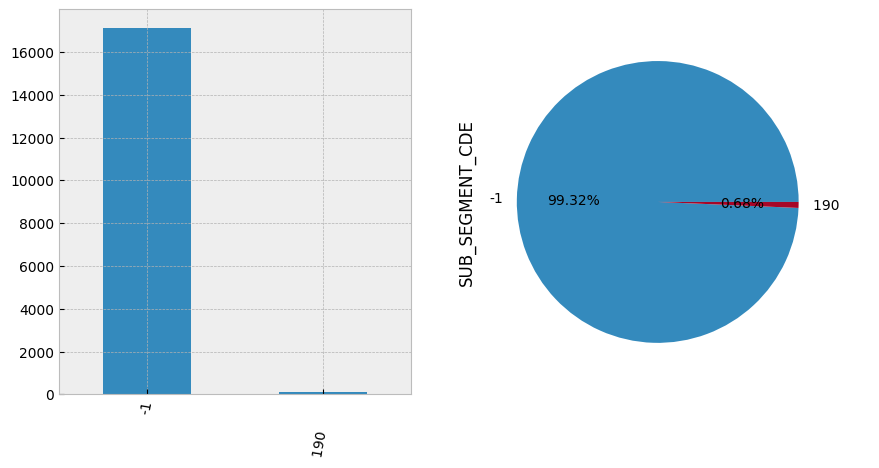

1022    2824
3014    1086
1027     936
2022     908
3004     839
        ... 
5137       5
4226       5
9043       2
4228       2
4276       2
Name: PRODUCT_CDE, Length: 109, dtype: int64

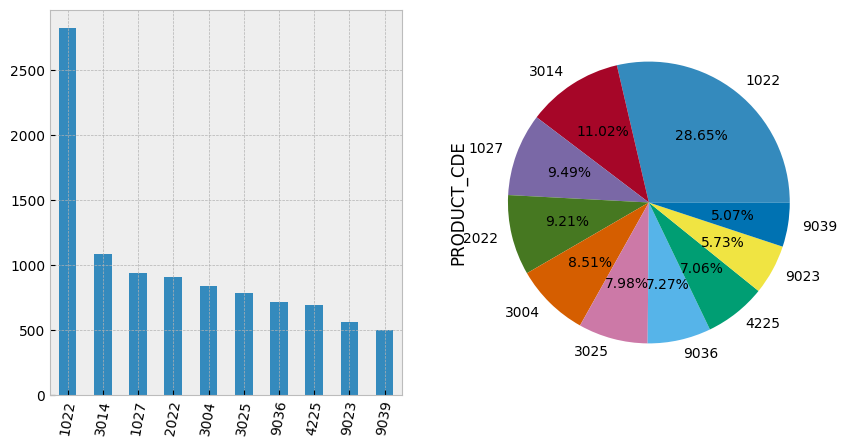

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,17241.000,9675.000,6534.000
count_pct_chg,100.000,-43.884,-62.102
mean,138675.792,247122.412,11.966
mean_pct_chg,100.000,78.202,-99.991
median,0.000,71612.420,12.562
median_pct_chg,100.000,inf,inf
min,-10101188.780,-10101188.780,3.771
min_pct_chg,100.000,-0.000,-100.000
max,15649477.790,15649477.790,16.566
max_pct_chg,100.000,0.000,-100.000


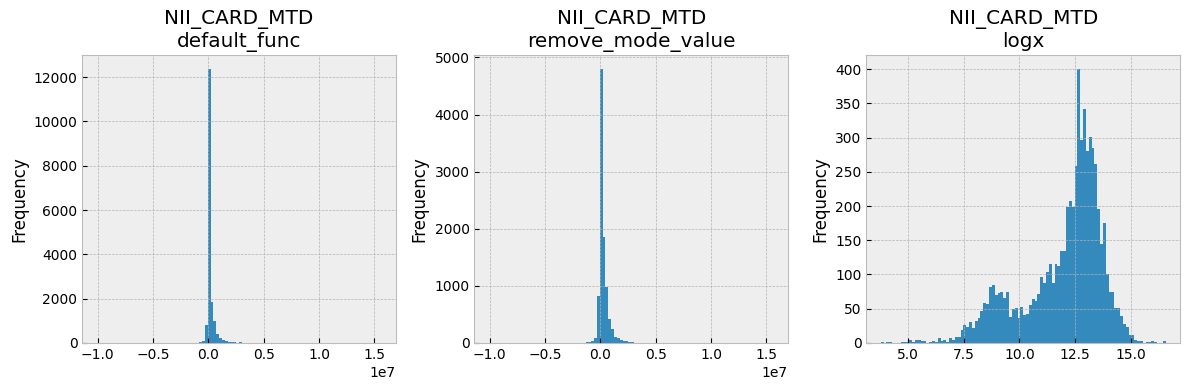

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,17241.000,13043.000,10269.000
count_pct_chg,100.000,-24.349,-40.438
mean,1429105.421,1889075.102,13.526
mean_pct_chg,100.000,32.186,-99.999
median,98676.195,522681.270,13.902
median_pct_chg,100.000,429.693,-99.986
min,-25538662.582,-25538662.582,2.623
min_pct_chg,100.000,-0.000,-100.000
max,28666248.625,28666248.625,17.171
max_pct_chg,100.000,0.000,-100.000


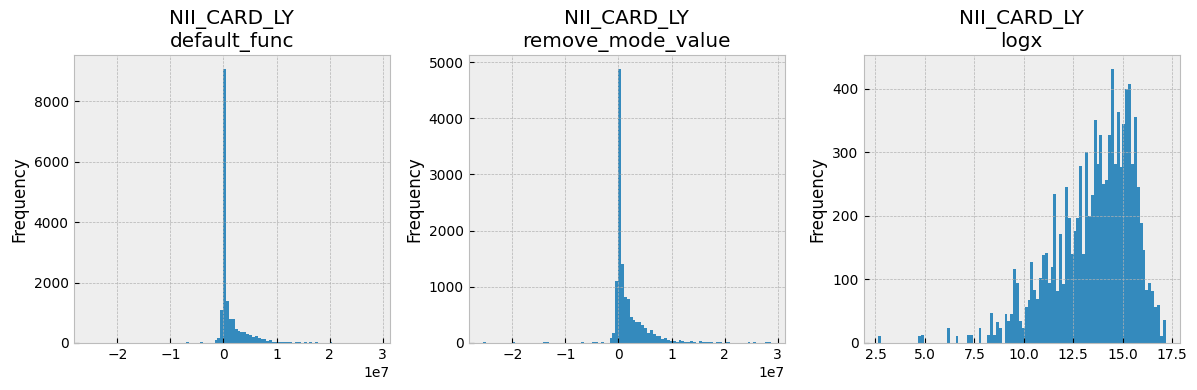

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,17241.000,13957.000,11179.000
count_pct_chg,100.000,-19.048,-35.160
mean,1603965.918,1981369.663,13.593
mean_pct_chg,100.000,23.529,-99.999
median,228201.804,576956.156,13.941
median_pct_chg,100.000,152.827,-99.994
min,-32587774.590,-32587774.590,2.623
min_pct_chg,100.000,-0.000,-100.000
max,33911043.580,33911043.580,17.339
max_pct_chg,100.000,0.000,-100.000


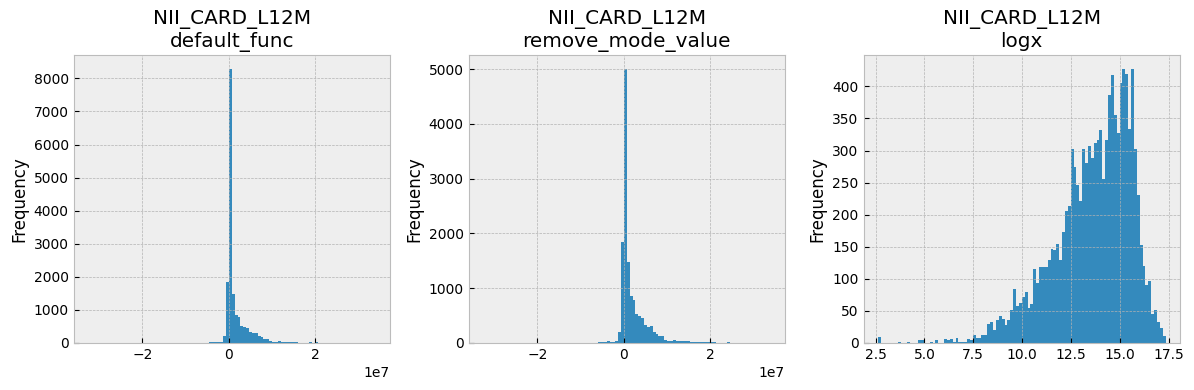

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,17241.000,12443.000,9564.000
count_pct_chg,100.000,-27.829,-44.528
mean,841107.043,1165436.513,13.229
mean_pct_chg,100.000,38.560,-99.998
median,36025.790,371867.410,13.693
median_pct_chg,100.000,932.226,-99.962
min,-26555012.085,-26555012.085,2.623
min_pct_chg,100.000,-0.000,-100.000
max,18087755.950,18087755.950,16.711
max_pct_chg,100.000,0.000,-100.000


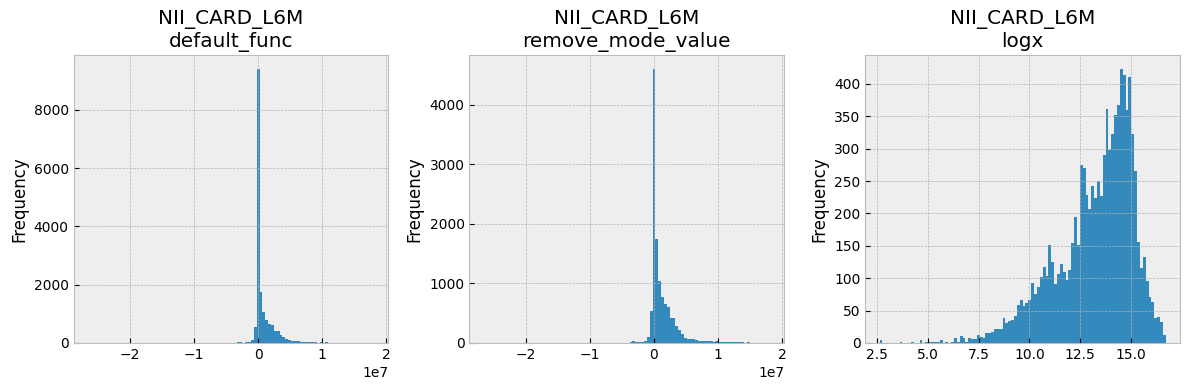

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,17241.000,12578.000,9727.000
count_pct_chg,100.000,-27.046,-43.582
mean,945380.407,1295858.133,13.239
mean_pct_chg,100.000,37.073,-99.999
median,47329.850,360151.731,13.564
median_pct_chg,100.000,660.940,-99.971
min,-19663363.781,-19663363.781,2.623
min_pct_chg,100.000,-0.000,-100.000
max,31029622.169,31029622.169,17.250
max_pct_chg,100.000,0.000,-100.000


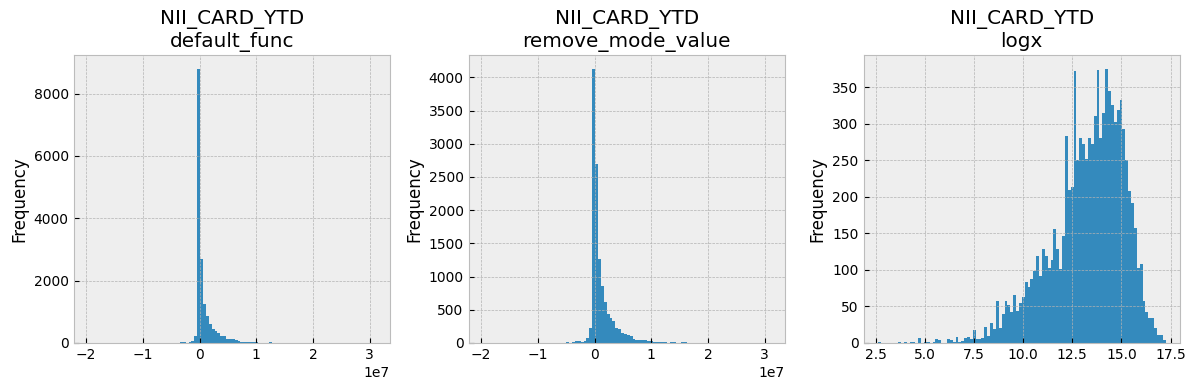

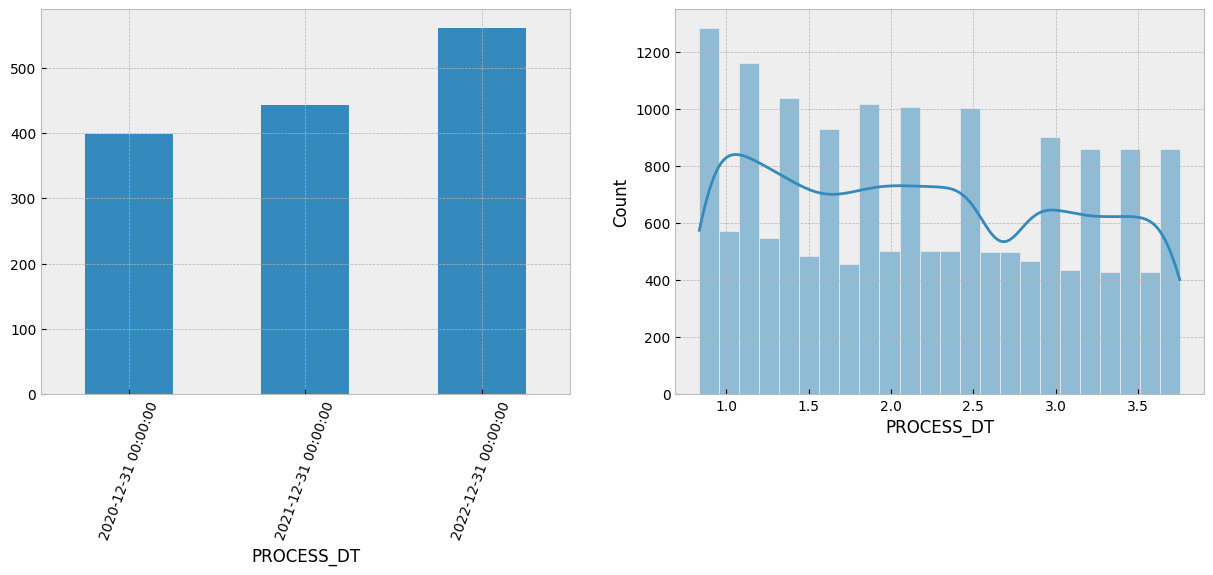

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,7453.000,7347.000,6345.000
count_pct_chg,100.000,-1.422,-14.866
mean,4214412.121,4275216.216,14.114
mean_pct_chg,100.000,1.443,-100.000
median,1096210.575,1146195.763,14.438
median_pct_chg,100.000,4.560,-99.999
min,-40871764.165,-40871764.165,2.623
min_pct_chg,100.000,-0.000,-100.000
max,101954603.790,101954603.790,18.440
max_pct_chg,100.000,0.000,-100.000


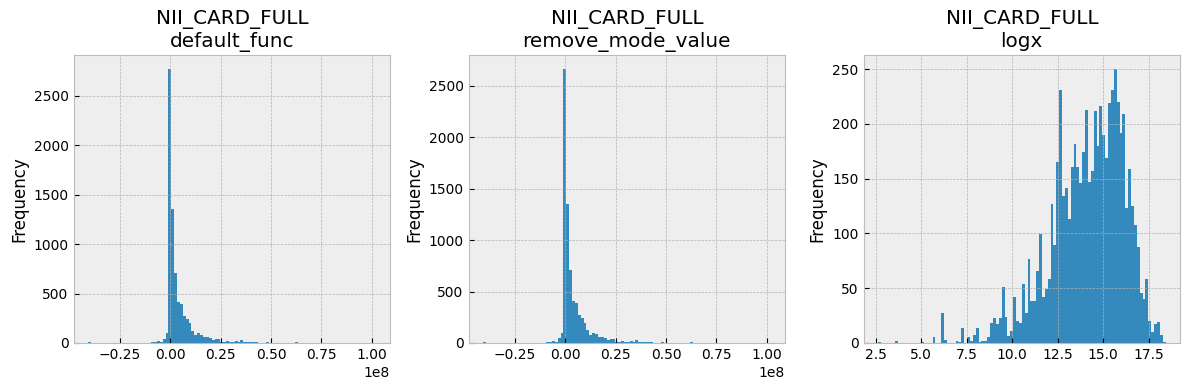

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['COMPANY_KEY', 'COMPANY_CDE', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE',
        'CUSTOMER_KEY', 'CUSTOMER_CDE', 'FIN_ACCOUNT', 'CARD_NO', 'CARD_CDE',
        'SUB_INDUSTRY_CDE', 'SUB_SECTOR_CDE', 'SUB_SEGMENT_CDE', 'DAO_KEY',
        'DAO_CDE', 'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'PRODUCT_CDE',
        'NII_CARD_MTD', 'NII_CARD_LY', 'NII_CARD_L12M', 'NII_CARD_L6M',
        'NII_CARD_YTD', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
        'NII_CARD_FULL'],
       dtype='object'),
 26)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['FIN_ACCOUNT', 'CARD_CDE', 'SUB_INDUSTRY_CDE', 'SUB_SEGMENT_CDE',
        'PRODUCT_CDE', 'NII_CARD_MTD', 'NII_CARD_LY', 'NII_CARD_L12M',
        'NII_CARD_L6M', 'NII_CARD_YTD', 'PROCESS_DT', 'NII_CARD_FULL'],
       dtype='object', name='Column'),
 12)

In [27]:
df.columns

Index(['COMPANY_KEY', 'COMPANY_CDE', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE',
       'CUSTOMER_KEY', 'CUSTOMER_CDE', 'FIN_ACCOUNT', 'CARD_NO', 'CARD_CDE',
       'SUB_INDUSTRY_CDE', 'SUB_SECTOR_CDE', 'SUB_SEGMENT_CDE', 'DAO_KEY',
       'DAO_CDE', 'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'PRODUCT_CDE',
       'NII_CARD_MTD', 'NII_CARD_LY', 'NII_CARD_L12M', 'NII_CARD_L6M',
       'NII_CARD_YTD', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
       'NII_CARD_FULL'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3